In [1]:
import pandas as pd
import numpy as np
import pickle
from ase import Atoms
from dscribe.descriptors import SOAP
from sklearn.decomposition import PCA

In [2]:
structures = pd.read_csv('../Data/structures.csv')

In [3]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


### node information

In [4]:
structures[['C', 'F', 'H', 'N', 'O']] = pd.get_dummies(structures.atom)
structures = structures.sort_values(by=['molecule_name', 'atom_index'])

In [5]:
structures_gb = structures.groupby(['molecule_name'])

In [7]:
species = ['C', 'F', 'H', 'N', 'O']
rcut = 8.0
nmax = 6
lmax = 4

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
)

In [8]:
structures_list = []
count_list = []
mol_list = []
for k,v in structures_gb:
    atom_dict = {'positions':v[['x','y','z']].values.tolist(),
                 'symbols':[i[0] for i in v[['atom']].values.tolist()]
                 }
    atom = Atoms(**atom_dict)
    dist = atom.get_all_distances()
    d = dist.shape[0]
    acsf_np = soap.create(atom)
    temp = np.concatenate([acsf_np,v[['C', 'F', 'H', 'N', 'O']].values],1)
    structures_list.append(temp)
    count_list.append(d)
    mol_list.append(k)

In [9]:
structures_list = np.concatenate(structures_list,0)

In [10]:
count_list = np.cumsum(np.array(count_list))

In [16]:
model = PCA(48,svd_solver='randomized',whiten=True)

In [17]:
structures_pca = model.fit_transform(structures_list).astype(np.float32)

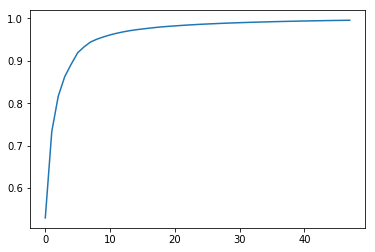

In [18]:
import matplotlib.pyplot as plt
plt.plot(model.explained_variance_ratio_.cumsum())

In [19]:
model.explained_variance_ratio_.sum()

0.9957779719134929

In [20]:
structures_pca2 = np.split(structures_pca,count_list)

In [27]:
len(structures_pca2[:-1]) - len(mol_list)

0

In [21]:
structures_dict = dict(zip(mol_list,structures_pca2[:-1]))

In [22]:
with open('../Data/structures_dict_SOAP_PCA.pickle', 'wb') as handle:
    pickle.dump(structures_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)